In [ ]:
# Install required external libraries (run once in Colab or new environment)
!pip install -q catboost lightgbm imbalanced-learn xgboost

# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Imbalance handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek


# About
The task is to develop a predictive model aimed at identifying early signs of student dropout in order to allocate appropriate resources for academic success. The dataset is provided for analysis to understand dropout patterns and potential root causes, facilitating the timely intervention to support students' academic journey.

# Data Loading and Preperation

In [ ]:
# Load data
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

# Strip extra spaces from column names
train_data.columns = train_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# Drop id columns if present
train_data.drop(columns=['id'], inplace=True, errors='ignore')
test_data.drop(columns=['id'], inplace=True, errors='ignore')

## Data Overview

In [ ]:
# Show all columns
pd.set_option('display.max_columns', None)
train_data.head()


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,43,1,9238,1,39,120.0,1,2,1,1,2,118.6,0,0,0,1,1,0,21,0,9,11,14,10,12.400000,0,6,10,13,10,11.800000,0,13.9,-0.3,0.79,Graduate
1,1,39,1,9130,1,1,133.1,1,1,1,90,1,120.0,1,0,1,0,1,0,41,0,0,5,5,0,0.000000,1,0,5,5,0,0.000000,5,12.7,3.7,-1.70,Dropout
2,1,44,1,9003,1,39,140.0,1,1,38,9,6,140.0,0,0,0,1,1,0,21,0,0,6,13,4,11.750000,0,0,6,15,4,10.500000,0,15.5,2.8,-4.06,Enrolled
3,1,16,1,9070,1,1,125.0,1,1,1,4,4,120.8,1,0,0,1,0,0,18,0,0,6,6,6,14.500000,0,0,6,6,6,12.833333,0,12.4,0.5,1.79,Graduate
4,1,17,1,9500,1,1,142.0,1,37,37,5,5,131.3,1,0,0,1,0,0,19,0,0,8,8,7,14.731429,0,0,8,8,7,14.731429,0,10.8,1.4,1.74,Graduate


In [ ]:
train_data.describe()


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000,3539.000000
mean,1.174343,18.660921,1.727042,8850.986719,0.892060,4.708675,132.684713,1.840068,19.461147,22.291325,10.815767,10.974569,126.876745,0.548743,0.011585,0.109918,0.881605,0.350664,0.252614,23.249506,0.024301,0.717152,6.265329,8.291325,4.701611,10.622981,0.139870,0.545352,6.226900,8.037864,4.433738,10.204514,0.139305,11.580136,1.222323,0.018632
std,0.597108,17.487095,1.307274,2081.250633,0.310349,10.436904,13.202248,6.862320,15.565408,15.323980,26.089260,25.267655,14.530706,0.497689,0.107024,0.312832,0.323121,0.477245,0.434573,7.605164,0.154003,2.379597,2.494418,4.187610,3.095471,4.871221,0.663121,1.923602,2.219626,3.968179,3.028096,5.235607,0.712547,2.660350,1.379769,2.271754
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,4.000000,4.000000,117.800000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.775000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,5.000000,7.000000,126.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.320000,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,9.000000,9.000000,134.900000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.399000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,108.000000,44.000000,44.000000,194.000000,195.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,70.000000,1.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [ ]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3539 entries, 0 to 3538
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  3539 non-null   int64  
 1   Application mode                                3539 non-null   int64  
 2   Application order                               3539 non-null   int64  
 3   Course                                          3539 non-null   int64  
 4   Daytime/evening attendance                      3539 non-null   int64  
 5   Previous qualification                          3539 non-null   int64  
 6   Previous qualification (grade)                  3539 non-null   float64
 7   Nacionality                                     3539 non-null   int64  
 8   Mother's qualification                          3539 non-null   int64  
 9   Father's qualification                   

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  885 non-null    int64  
 1   Application mode                                885 non-null    int64  
 2   Application order                               885 non-null    int64  
 3   Course                                          885 non-null    int64  
 4   Daytime/evening attendance                      885 non-null    int64  
 5   Previous qualification                          885 non-null    int64  
 6   Previous qualification (grade)                  885 non-null    float64
 7   Nacionality                                     885 non-null    int64  
 8   Mother's qualification                          885 non-null    int64  
 9   Father's qualification                     

## Target Distribution

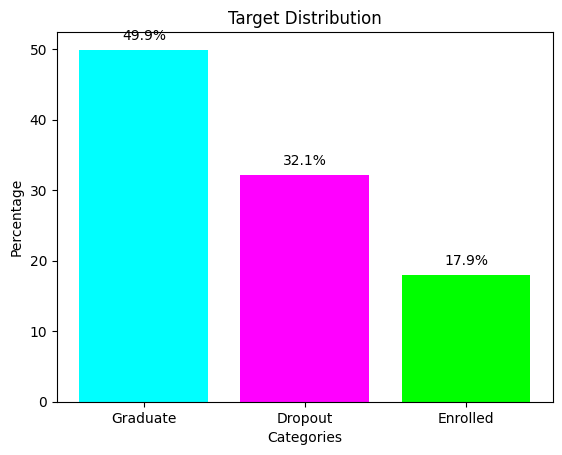

In [ ]:
tg_cnts = train_data.Target.value_counts()
tg_cnts_sum = tg_cnts.sum()
tg_cnts_pct = (tg_cnts / tg_cnts_sum) * 100

# Plot
colors = ['#00FFFF', '#FF00FF', '#00FF00']  # Neon blue, magenta, lime green

plt.bar(tg_cnts.index, tg_cnts_pct, color=colors)
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title('Target Distribution')

# Percentages on bars
for i, pct in enumerate(tg_cnts_pct):
    plt.text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom')

plt.show()

### Feature Cardinality Check

In [ ]:
data = []

for col in train_data.columns:
    if col == 'Target':
        continue
    unique_count = train_data[col].nunique()
    data.append({'feature': col, 'unique_count': unique_count})

feature_count = pd.DataFrame(data).sort_values(by='unique_count')
print(feature_count)


                                           feature  unique_count
4                       Daytime/evening attendance             2
13                                       Displaced             2
15                                          Debtor             2
14                       Educational special needs             2
20                                   International             2
18                              Scholarship holder             2
17                                          Gender             2
16                         Tuition fees up to date             2
0                                   Marital status             6
2                                Application order             8
34                                  Inflation rate             9
32  Curricular units 2nd sem (without evaluations)            10
35                                             GDP            10
33                               Unemployment rate            10
26  Curricular units 1st 

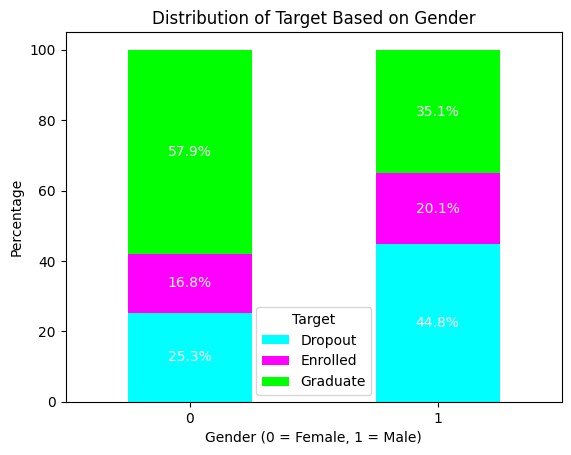

In [ ]:
# Target Distribution by Gender
crosstab_gender = pd.crosstab(train_data['Gender'], train_data['Target'])
crosstab_gender = crosstab_gender.div(crosstab_gender.sum(axis=1), axis=0) * 100

# Plot
colors = ['#00FFFF', '#FF00FF', '#00FF00']  # Neon blue, magenta, lime green
ax_gender = crosstab_gender.plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Gender (0 = Female, 1 = Male)')
plt.ylabel('Percentage')
plt.title('Distribution of Target Based on Gender')
plt.legend(title='Target')
plt.xticks(rotation=0)

for p in ax_gender.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax_gender.annotate(
        f'{height:.1f}%',
        (x + width / 2, y + height / 2),
        ha='center',
        va='center',
        fontsize=10,
        color='white'
    )

plt.show()

In [ ]:
crosstab_gender

Target,Dropout,Enrolled,Graduate
Gender,,,
0,25.282855,16.797215,57.919930
1,44.802579,20.064464,35.132957


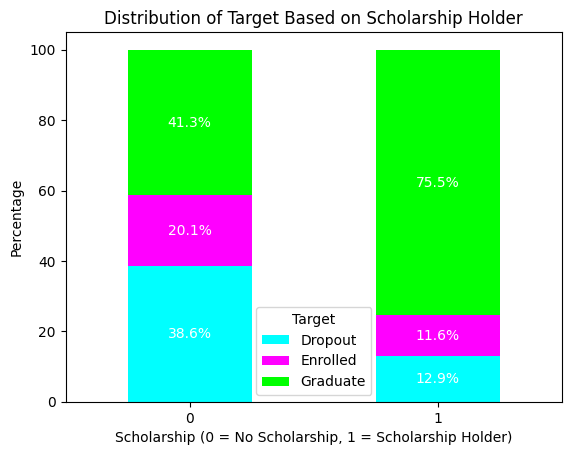

In [ ]:
# Create a crosstab to count the occurrences of each Target value for each Scholarship status
crosstab_ss = pd.crosstab(train_data['Scholarship holder'], train_data['Target'])

# Normalize the crosstab counts to percentages
crosstab_ss = crosstab_ss.div(crosstab_ss.sum(axis=1), axis=0) * 100

# Plot the data
colors = ['#00FFFF', '#FF00FF', '#00FF00']  # Neon blue, magenta, lime green
ax_ss = crosstab_ss.plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Scholarship (0 = No Scholarship, 1 = Scholarship Holder)')
plt.ylabel('Percentage')
plt.title('Distribution of Target Based on Scholarship Holder')
plt.legend(title='Target')
plt.xticks(rotation=0)

# Annotate the percentage labels on each bar
for p in ax_ss.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax_ss.annotate(
        f'{height:.1f}%',
        (x + width / 2, y + height / 2),
        ha='center',
        va='center',
        fontsize=10,
        color='white'
    )

plt.show()

In [ ]:
crosstab_ss

Target,Dropout,Enrolled,Graduate
Scholarship holder,,,
0,38.638941,20.075614,41.285444
1,12.863535,11.633110,75.503356


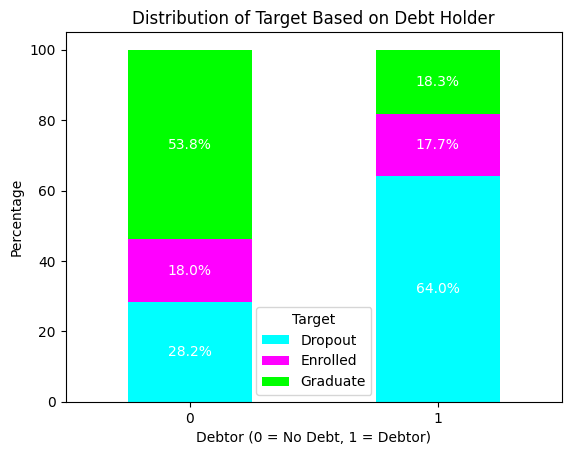

In [ ]:
# Create a crosstab to count the occurrences of each Target value for each Debtor status
crosstab_debtor = pd.crosstab(train_data['Debtor'], train_data['Target'])

# Normalize the crosstab counts to percentages
crosstab_debtor = crosstab_debtor.div(crosstab_debtor.sum(axis=1), axis=0) * 100

# Plot the data
colors = ['#00FFFF', '#FF00FF', '#00FF00']  # Neon blue, magenta, lime green
ax_debtor = crosstab_debtor.plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Debtor (0 = No Debt, 1 = Debtor)')
plt.ylabel('Percentage')
plt.title('Distribution of Target Based on Debt Holder')
plt.legend(title='Target')
plt.xticks(rotation=0)

# Annotate the percentage labels on each bar
for p in ax_debtor.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax_debtor.annotate(
        f'{height:.1f}%',
        (x + width / 2, y + height / 2),
        ha='center',
        va='center',
        fontsize=10,
        color='white'
    )

plt.show()

In [ ]:
crosstab_debtor

Target,Dropout,Enrolled,Graduate
Debtor,,,
0,28.190476,17.968254,53.841270
1,64.010283,17.737789,18.251928


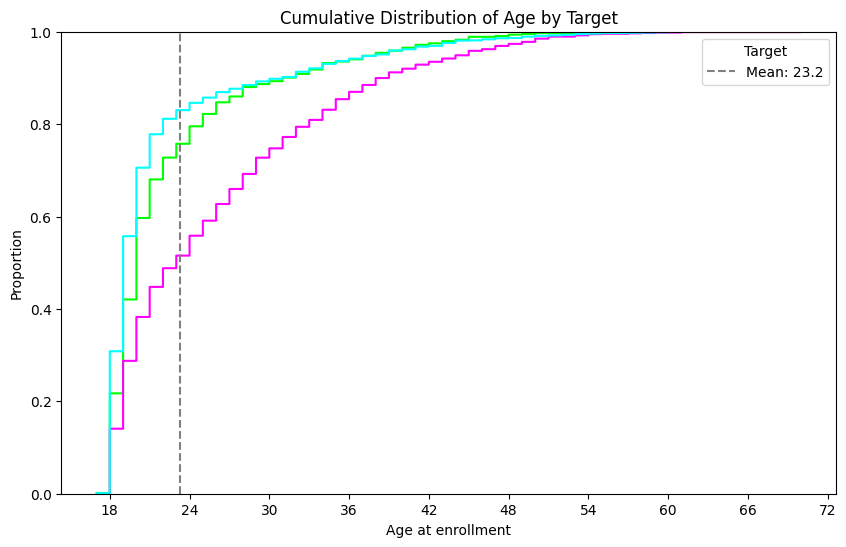

In [ ]:
### Age Distribution by Target (ECDF)

plt.figure(figsize=(10, 6))
colors = ['#00FFFF', '#FF00FF', '#00FF00']  # Neon blue, magenta, lime green
plot = sns.ecdfplot(data=train_data, x='Age at enrollment', hue='Target', palette=colors)
plt.xlabel('Age at enrollment')
plt.ylabel('Proportion')
plt.title('Cumulative Distribution of Age by Target')
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

mean_value = train_data['Age at enrollment'].mean()
plt.axvline(mean_value, color='grey', linestyle='--', label=f'Mean: {mean_value:.1f}')

plt.legend(title='Target')
plt.show()

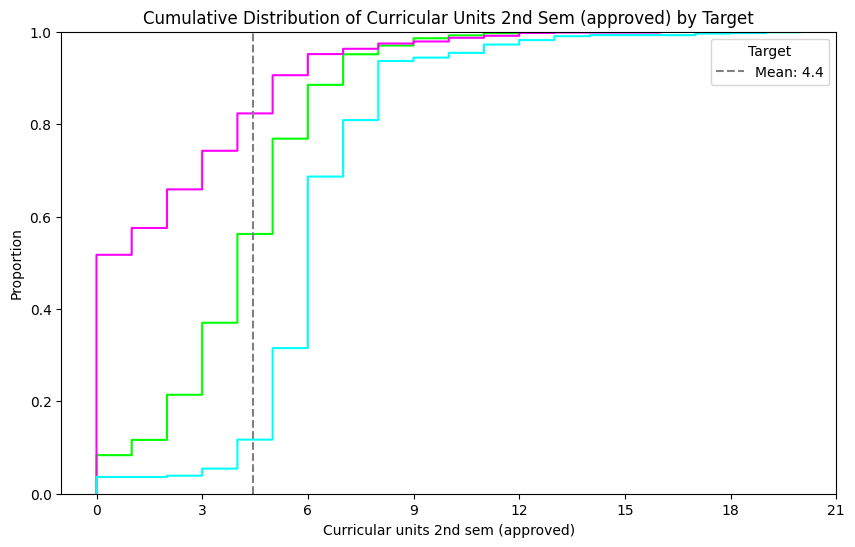

In [ ]:
### Approved 2nd Semester Units by Target (ECDF)

plt.figure(figsize=(10, 6))
colors = ['#00FFFF', '#FF00FF', '#00FF00']  # Neon blue, magenta, lime green
plot = sns.ecdfplot(
    data=train_data,
    x='Curricular units 2nd sem (approved)',
    hue='Target',
    palette=colors
)

plt.xlabel('Curricular units 2nd sem (approved)')
plt.ylabel('Proportion')
plt.title('Cumulative Distribution of Curricular Units 2nd Sem (approved) by Target')
plot.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

mean_value = train_data['Curricular units 2nd sem (approved)'].mean()
plt.axvline(mean_value, color='grey', linestyle='--', label=f'Mean: {mean_value:.1f}')

plt.legend(title='Target')
plt.show()

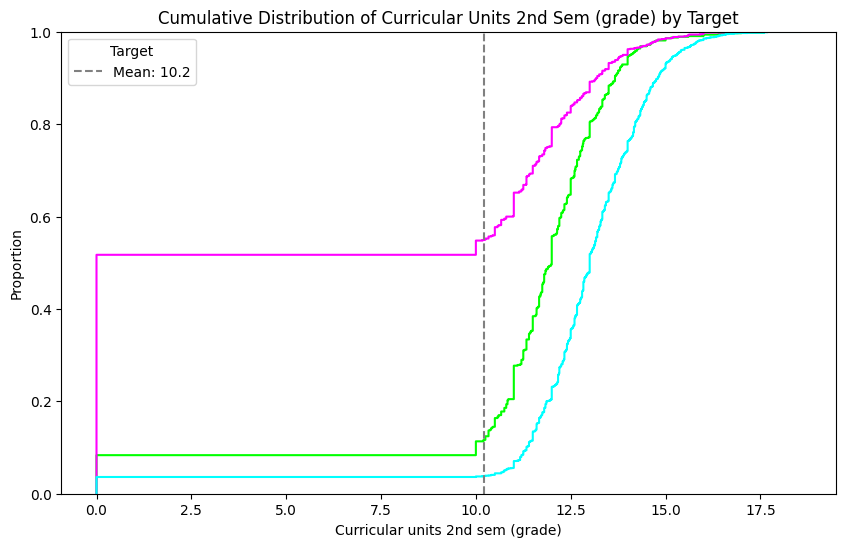

In [ ]:
### 2nd Semester Grade Distribution by Target (ECDF)

plt.figure(figsize=(10, 6))
colors = ['#00FFFF', '#FF00FF', '#00FF00']  # Neon blue, magenta, lime green
plot = sns.ecdfplot(
    data=train_data,
    x='Curricular units 2nd sem (grade)',
    hue='Target',
    palette=colors
)

plt.xlabel('Curricular units 2nd sem (grade)')
plt.ylabel('Proportion')
plt.title('Cumulative Distribution of Curricular Units 2nd Sem (grade) by Target')

mean_value = train_data['Curricular units 2nd sem (grade)'].mean()
plt.axvline(mean_value, color='grey', linestyle='--', label=f'Mean: {mean_value:.1f}')

plt.legend(title='Target')
plt.show()

# Plotting (grouped by Data Types)

In [ ]:
### Identification of Categorical Features

# Identify categorical columns based on low cardinality
cat_cols = [
    col for col in train_data.columns
    if col != 'Target' and train_data[col].nunique() <= 8
]

# Convert to categorical dtype (for CatBoost compatibility later)
for col in cat_cols:
    train_data[col] = train_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

print("Categorical columns:")
print(cat_cols)


Categorical columns:
['Marital status', 'Application order', 'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']


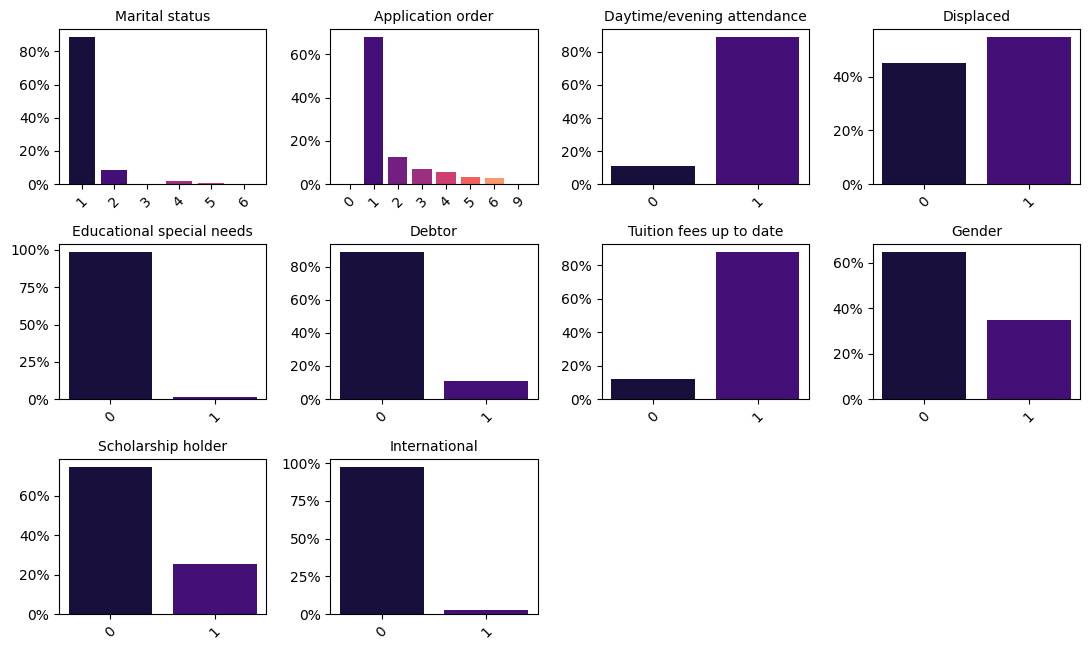

In [ ]:
# Categorical feature distributions
n_cols = 4
n_rows = int(np.ceil(len(cat_cols) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(11, 2.2 * n_rows))
axs = np.array(axs).ravel()

# Define a cyberpunk color palette
cyberpunk_palette = sns.color_palette('magma', n_colors=8)

for ax, col in zip(axs, cat_cols):
    vc = train_data[col].value_counts(normalize=True).sort_index()
    # Use the color palette for bars, cycling through it if more categories than colors
    ax.bar(vc.index.astype(str), vc, color=cyberpunk_palette[:len(vc)])
    ax.set_title(col, fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.tick_params(axis='x', labelrotation=45)

# Turn off any unused axes
for ax in axs[len(cat_cols):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

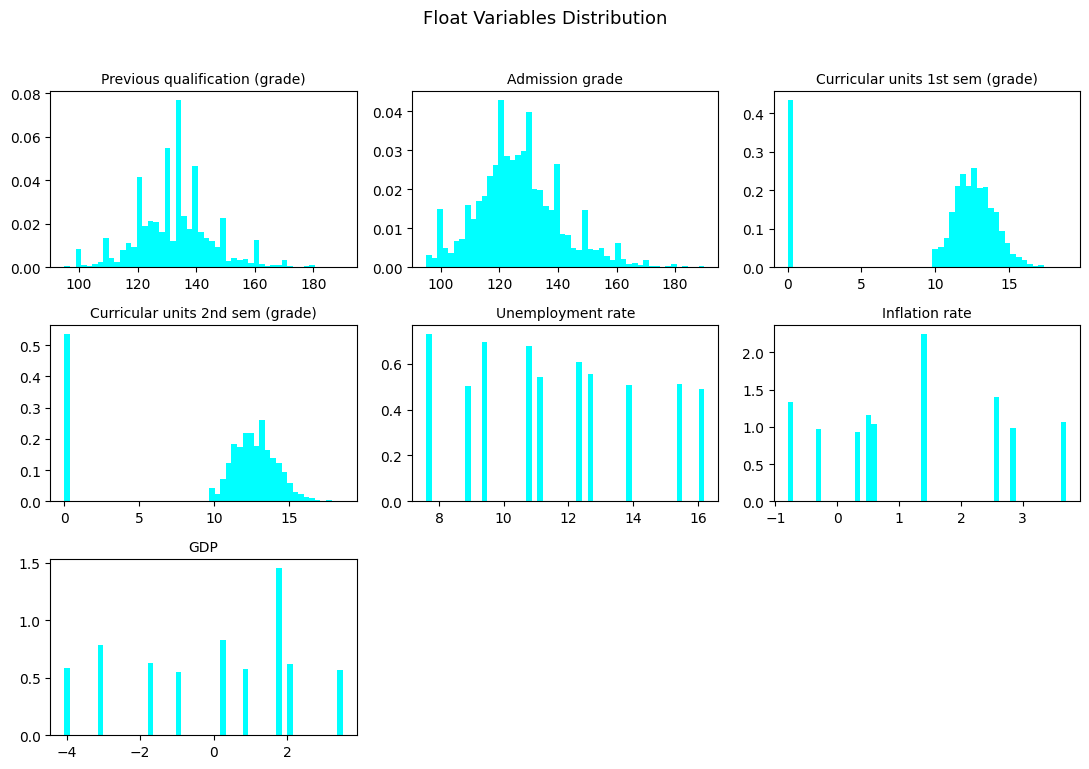

In [ ]:
### Continuous Feature Distributions

# Float feature distributions
float_cols = [
    col for col in train_data.columns
    if col != 'Target' and train_data[col].dtype == 'float64'
]

n_cols = 3
n_rows = int(np.ceil(len(float_cols) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(11, 2.5 * n_rows))
axs = np.array(axs).ravel()

for ax, col in zip(axs, float_cols):
    ax.hist(train_data[col], bins=50, density=True, color='#00FFFF') # Neon blue
    ax.set_title(col, fontsize=10)

# Turn off unused axes
for ax in axs[len(float_cols):]:
    ax.axis('off')

plt.suptitle('Float Variables Distribution', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

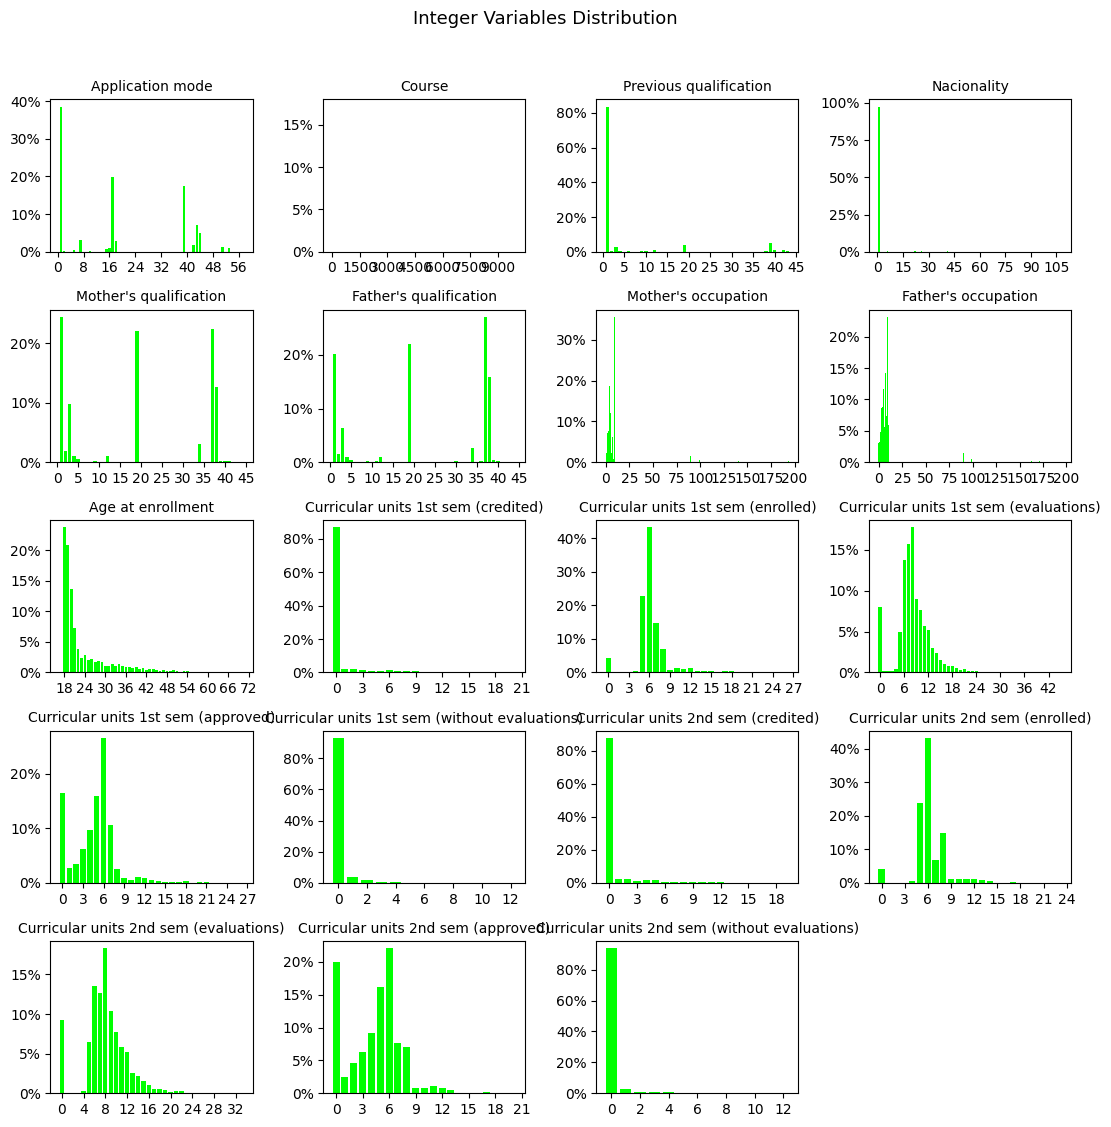

In [ ]:
# Integer feature distributions
int_cols = [
    col for col in train_data.columns
    if col != 'Target' and train_data[col].dtype == 'int64'
]

n_cols = 4
n_rows = int(np.ceil(len(int_cols) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(11, 2.2 * n_rows))
axs = np.array(axs).ravel()

for ax, col in zip(axs, int_cols):
    vc = train_data[col].value_counts(normalize=True).sort_index()
    ax.bar(vc.index, vc, color='#00FF00') # Lime green
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.set_title(col, fontsize=10)

# Turn off unused axes
for ax in axs[len(int_cols):]:
    ax.axis('off')

plt.suptitle('Integer Variables Distribution', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

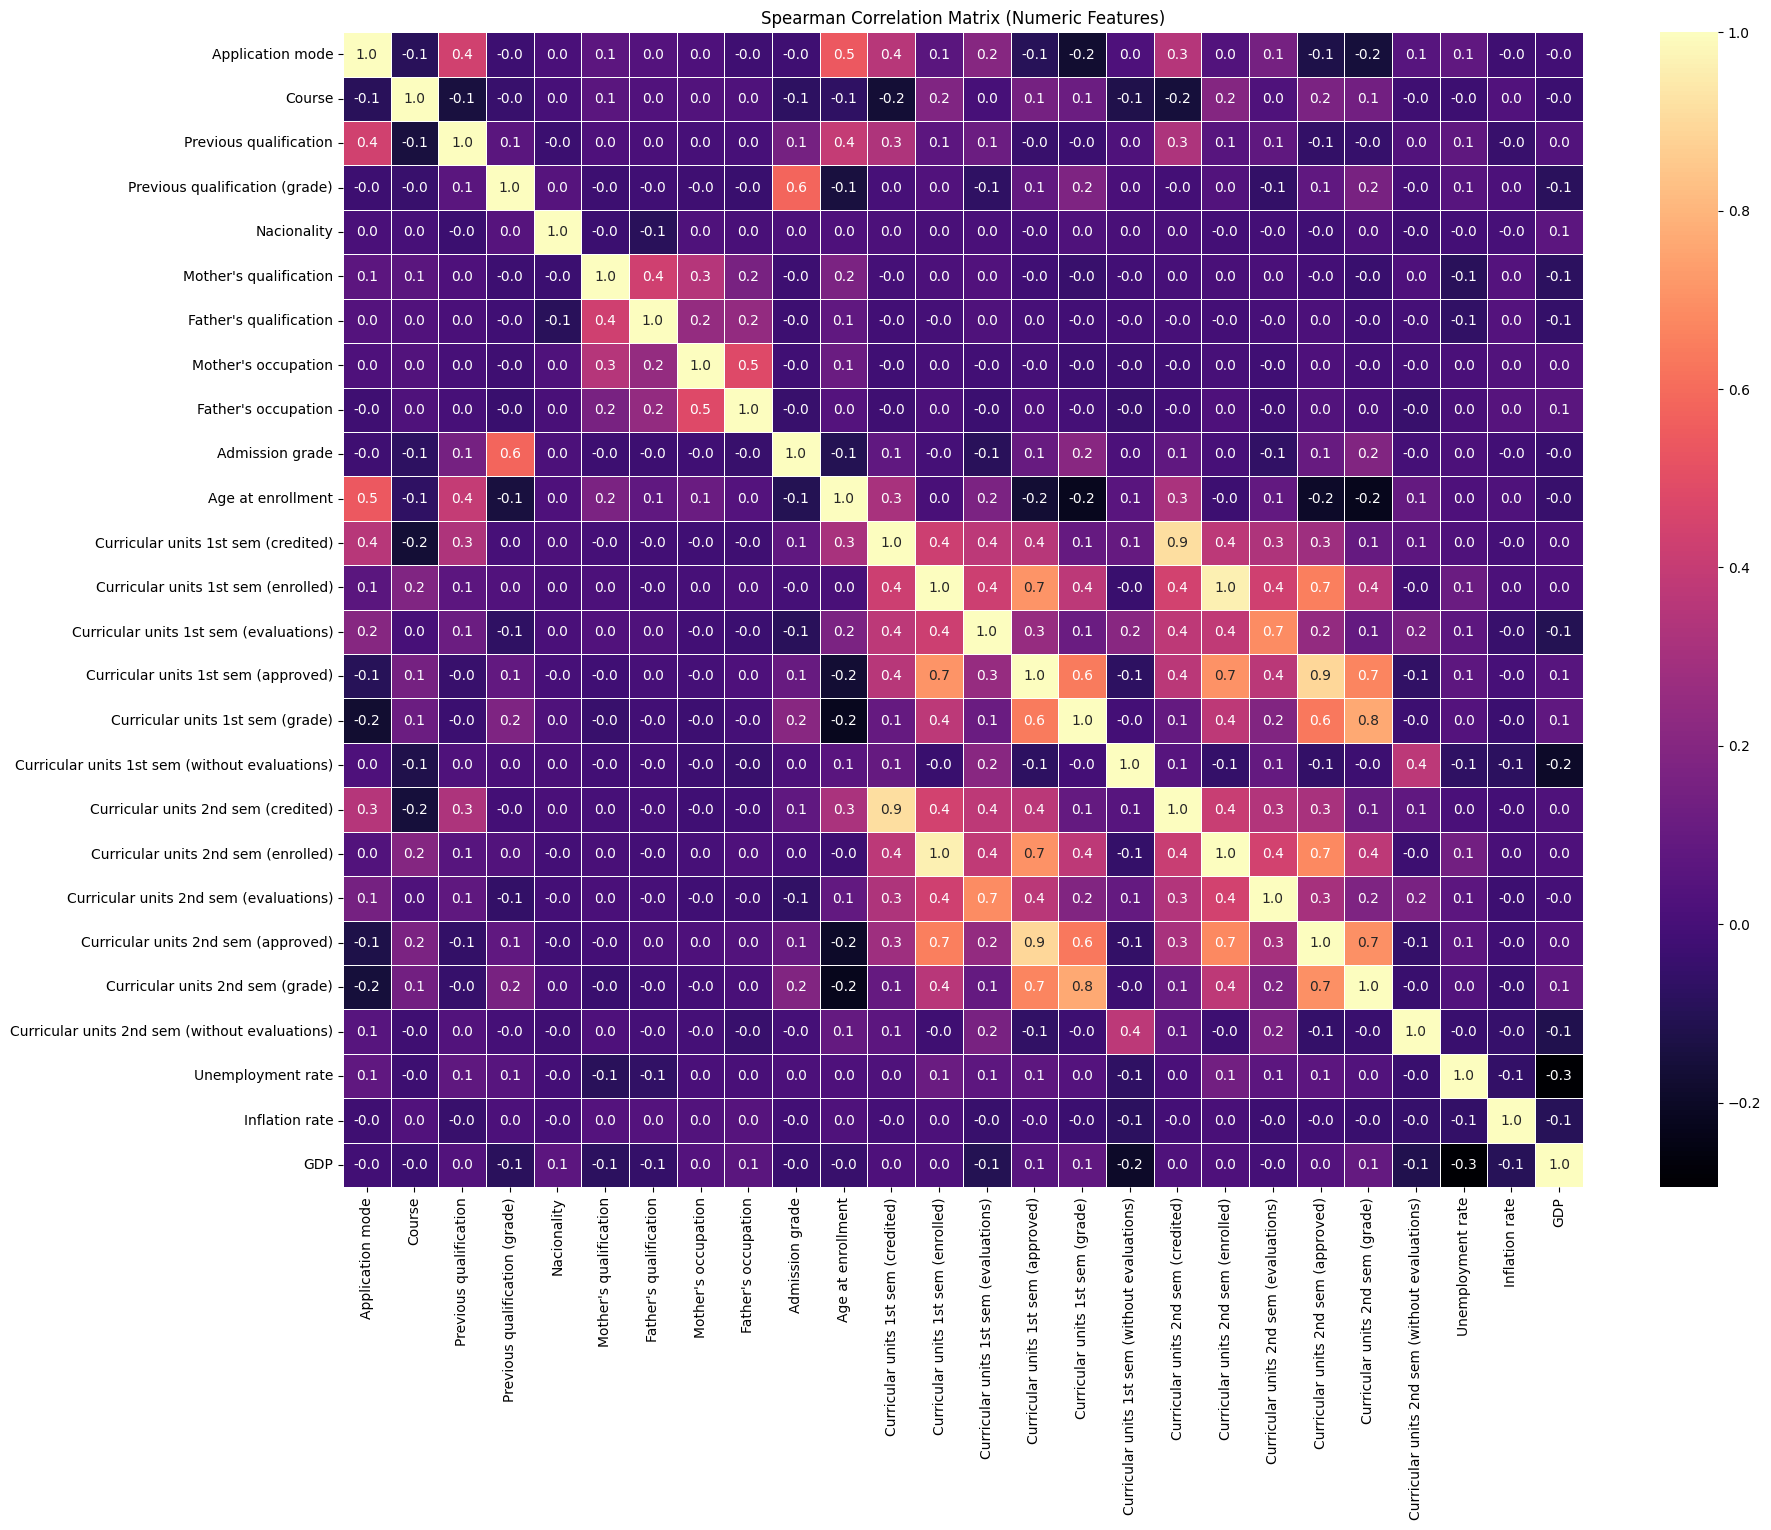

In [ ]:
### Spearman Correlation Analysis

# Select numeric features only (exclude Target)
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'Target']

plt.figure(figsize=(20, 15))
sns.heatmap(
    train_data[numeric_cols].corr(method='spearman'),
    cmap='magma',
    annot=True,
    fmt='.1f',
    linewidths=0.5
)
plt.title('Spearman Correlation Matrix (Numeric Features)')
plt.show()

#### Table 1: Descriptive Statistics for Selected Numerical Features

| Statistic          | Age at Enrollment | Admission Grade | Curricular Units 2nd Sem (Grade) | Unemployment Rate | Inflation Rate | GDP     |
|:-------------------|:------------------|:----------------|:---------------------------------|:------------------|:---------------|:--------|
| Count              | 3539.0            | 3539.0          | 3539.0                           | 3539.0            | 3539.0         | 3539.0  |
| Mean               | 23.3              | 126.88          | 11.23                            | 11.5              | 1.23           | 1.76    |
| Std                | 6.13              | 14.53           | 2.94                             | 2.62              | 1.63           | 2.33    |
| Min                | 17.0              | 95.0            | 0.0                              | 7.6               | -0.8           | -4.06   |
| 25%                | 19.0              | 117.8           | 10.33                            | 9.4               | 0.3            | 0.58    |
| 50%                | 21.0              | 126.0           | 12.0                             | 11.1              | 1.4            | 1.74    |
| 75%                | 25.0              | 134.9           | 13.0                             | 13.9              | 2.6            | 3.26    |
| Max                | 70.0              | 190.0           | 18.0                             | 16.2              | 3.7            | 3.51    |


#### Table 2: Unique Value Counts per Feature (Top and Bottom)

| Feature                                          | Unique Count |
|:-------------------------------------------------|:-------------|
| Daytime/evening attendance                       | 2            |
| Displaced                                        | 2            |
| Debtor                                           | 2            |
| Educational special needs                        | 2            |
| International                                    | 2            |
| Scholarship holder                               | 2            |
| Gender                                           | 2            |
| Tuition fees up to date                          | 2            |
| Marital status                                   | 6            |
| Application order                                | 8            |
| ...                                              | ...          |
| Age at enrollment                                | 46           |
| Previous qualification (grade)                   | 99           |
| Admission grade                                  | 591          |
| Curricular units 2nd sem (grade)                 | 674          |
| Curricular units 1st sem (grade)                 | 683          |


#### Table 3: Target Distribution by Gender (Percentages)

| Gender | Dropout | Enrolled | Graduate |
|:-------|:--------|:---------|:---------|
| 0      | 25.28   | 16.80    | 57.92    |
| 1      | 44.80   | 20.06    | 35.13    |


#### Table 4: Target Distribution by Scholarship Holder Status (Percentages)

| Scholarship Holder | Dropout | Enrolled | Graduate |
|:-------------------|:--------|:---------|:---------|
| 0                  | 38.64   | 20.08    | 41.29    |
| 1                  | 12.86   | 11.63    | 75.50    |


#### Table 5: Target Distribution by Debtor Status (Percentages)

| Debtor | Dropout | Enrolled | Graduate |
|:-------|:--------|:---------|:---------|
| 0      | 28.19   | 17.97    | 53.84    |
| 1      | 64.01   | 17.74    | 18.25    |


#### Table 6: Comparative Performance of Models with Different Sampling Techniques (Macro F1-Score Sorted)

| Sampler    | Model        | Accuracy | Precision (macro) | Recall (macro) | F1-Macro | F1-Weighted |
|:-----------|:-------------|:---------|:------------------|:---------------|:---------|:------------|
| SMOTETomek | XGBoost      | 0.7782   | 0.7273            | 0.7052         | 0.7131   | 0.7708      |
| SMOTETomek | LightGBM     | 0.7768   | 0.7281            | 0.7037         | 0.7124   | 0.7692      |
| SMOTETomek | RandomForest | 0.7684   | 0.7152            | 0.7037         | 0.7086   | 0.7655      |
| SMOTE      | XGBoost      | 0.7768   | 0.7215            | 0.7008         | 0.7079   | 0.7686      |
| None       | XGBoost      | 0.7811   | 0.7270            | 0.6991         | 0.7070   | 0.7699      |


#### Table 7: Permutation Feature Importance for the Best Pipeline (XGBoost + SMOTETomek)

| Feature                                | Importance Mean | Importance Std |
|:---------------------------------------|:----------------|:---------------|
| Curricular units 2nd sem (approved)    | 0.1831          | 0.0208         |
| Tuition fees up to date                | 0.0309          | 0.0104         |
| Curricular units 1st sem (approved)    | 0.0280          | 0.0071         |
| Course                                 | 0.0258          | 0.0072         |
| Mother's occupation                    | 0.0230          | 0.0041         |
| Curricular units 2nd sem (grade)       | 0.0169          | 0.0072         |
| Curricular units 2nd sem (enrolled)    | 0.0166          | 0.0072         |
| Age at enrollment                      | 0.0155          | 0.0070         |
| Curricular units 2nd sem (evaluations) | 0.0143          | 0.0098         |
| Admission grade                        | 0.0111          | 0.0072         |


## Model Preprocessing and Pipeline

* In this section, I implement the machine learning pipeline used to evaluate multiclass prediction of student outcomes (Graduate, Dropout, Enrolled). The goal is to compare several classifiers and class imbalance techniques to determine which combination produces the best predictive performance.

* The pipeline follows a structured sequence of steps. First, the target variable is encoded into numeric class labels. The dataset is then split into stratified training and validation sets to preserve the class distribution. Next, numeric and categorical features are preprocessed using imputation and one-hot encoding to create a fully numeric feature space suitable for modeling.

* To address class imbalance, multiple sampling techniques are applied to the training data, including Random Under Sampling (RUS), Random Over Sampling (ROS), SMOTE, SMOTE-ENN, and SMOTE-Tomek. Each balancing method is paired with multiple classifiers, including Random Forest, XGBoost, and LightGBM.

* Model performance is evaluated using multiclass metrics, with macro F1-score serving as the primary selection criterion because it treats each class equally. All model–balancing combinations are compared, and the best-performing pipeline is selected for detailed evaluation using a confusion matrix and permutation feature importance.

* This process directly addresses the research questions concerning the effect of class imbalance methods and the comparative performance of ensemble and gradient boosting models.

In [ ]:
# Defining X,y, and Encoding Multiclass Target

# Separate features and target
X = train_data.drop(columns=['Target'])
y = train_data['Target'].astype(str)  # ensure string labels

# Encode target to integers for models that require numeric targets
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

# Keep mapping for interpretation later
target_classes = list(label_encoder.classes_)
class_map = {cls: int(label_encoder.transform([cls])[0]) for cls in target_classes}

print("Target classes:", target_classes)
print("Class mapping:", class_map)


Target classes: ['Dropout', 'Enrolled', 'Graduate']
Class mapping: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}


In [ ]:
# Stratified Train/Validation Split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc,
    test_size=0.20,
    random_state=42,
    stratify=y_enc
)

print("Train shape:", X_train.shape, "Val shape:", X_val.shape)


Train shape: (2831, 36) Val shape: (708, 36)


In [ ]:
## Indentifying Feature Types and Building the Pipeline

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical cols:", len(cat_cols))
print("Numeric cols:", len(num_cols))

# Preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)



Categorical cols: 10
Numeric cols: 26


In [ ]:
# Here I define samplers for imbalance experiments

samplers = {
    "None": None,
    "RUS": RandomUnderSampler(random_state=42),
    "ROS": RandomOverSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42),
}


In [ ]:
# Here I define my models

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        objective="multiclass",
        num_class=3,
        n_estimators=800,
        learning_rate=0.05,
        random_state=42,
        n_jobs=-1
    )
}


In [ ]:
# This is an evaluation helper for multiclass metrics

def evaluate_multiclass(y_true, y_pred, class_names):
    results = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted", zero_division=0),
    }
    print(pd.Series(results).round(4))
    print("\nClassification Report (macro focus):\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    return results


In [ ]:
# Here I train and compare my models and balanacing methods

all_results = []

for sampler_name, sampler in samplers.items():
    for model_name, model in models.items():

        # Build imblearn pipeline (sampler must occur AFTER preprocessing)
        steps = [("preprocess", preprocessor)]
        if sampler is not None:
            steps.append(("sampler", sampler))
        steps.append(("model", model))

        pipe = ImbPipeline(steps=steps)

        # Fit and predict
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_val)

        # Collect metrics
        results = {
            "sampler": sampler_name,
            "model": model_name
        }
        results.update({
            "accuracy": accuracy_score(y_val, y_pred),
            "precision_macro": precision_score(y_val, y_pred, average="macro", zero_division=0),
            "recall_macro": recall_score(y_val, y_pred, average="macro", zero_division=0),
            "f1_macro": f1_score(y_val, y_pred, average="macro", zero_division=0),
            "f1_weighted": f1_score(y_val, y_pred, average="weighted", zero_division=0),
        })

        all_results.append(results)

results_df = pd.DataFrame(all_results).sort_values(by="f1_macro", ascending=False)
results_df.head(15)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 2831, number of used features: 51
[LightGBM] [Info] Start training from score -1.134941
[LightGBM] [Info] Start training from score -1.717904
[LightGBM] [Info] Start training from score -0.694915


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1208
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 49
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1285
[LightGBM] [Info] Number of data points in the train set: 4239, number of used features: 51
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8719
[LightGBM] [Info] Number of data points in the train set: 4239, number of used features: 52
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7131
[LightGBM] [Info] Number of data points in the train set: 1973, number of used features: 51
[LightGBM] [Info] Start training from score -1.180431
[LightGBM] [Info] Start training from score -0.769480
[LightGBM] [Info] Start training from score -1.471418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8692
[LightGBM] [Info] Number of data points in the train set: 4043, number of used features: 52
[LightGBM] [Info] Start training from score -1.102826
[LightGBM] [Info] Start training from score -1.077080
[LightGBM] [Info] Start training from score -1.116330


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,sampler,model,accuracy,precision_macro,recall_macro,f1_macro,f1_weighted
16,SMOTETomek,XGBoost,0.778249,0.727299,0.705172,0.713140,0.770840
17,SMOTETomek,LightGBM,0.776836,0.728053,0.703704,0.712409,0.769219
15,SMOTETomek,RandomForest,0.768362,0.715193,0.703733,0.708631,0.765513
10,SMOTE,XGBoost,0.776836,0.721509,0.700762,0.707852,0.768635
1,None,XGBoost,0.781073,0.726966,0.699064,0.706979,0.769869
11,SMOTE,LightGBM,0.775424,0.721091,0.699294,0.706801,0.767214
2,None,LightGBM,0.776836,0.721827,0.694659,0.702748,0.765982
7,ROS,XGBoost,0.769774,0.712720,0.695630,0.702065,0.763266
9,SMOTE,RandomForest,0.766949,0.709905,0.695005,0.700948,0.761857
14,SMOTEENN,LightGBM,0.733051,0.701957,0.713956,0.699780,0.745610


Best sampler: SMOTETomek
Best model: XGBoost
accuracy           0.7782
precision_macro    0.7273
recall_macro       0.7052
f1_macro           0.7131
f1_weighted        0.7708
dtype: float64

Classification Report (macro focus):

              precision    recall  f1-score   support

     Dropout       0.82      0.78      0.80       227
    Enrolled       0.55      0.43      0.48       127
    Graduate       0.82      0.90      0.85       354

    accuracy                           0.78       708
   macro avg       0.73      0.71      0.71       708
weighted avg       0.77      0.78      0.77       708



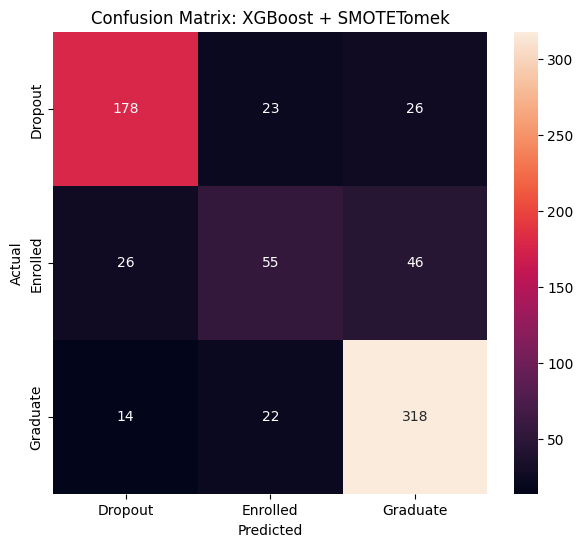

In [ ]:
# Now I will select the best pipeline and show confusion matrix

best_row = results_df.iloc[0]
best_sampler = best_row["sampler"]
best_model = best_row["model"]

print("Best sampler:", best_sampler)
print("Best model:", best_model)

# Rebuild the best pipeline
steps = [("preprocess", preprocessor)]
if best_sampler != "None":
    steps.append(("sampler", samplers[best_sampler]))
steps.append(("model", models[best_model]))

best_pipe = ImbPipeline(steps=steps)
best_pipe.fit(X_train, y_train)

y_pred_best = best_pipe.predict(X_val)

# Metrics
evaluate_multiclass(y_val, y_pred_best, target_classes)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: {best_model} + {best_sampler}")
plt.show()


CatBoost Results:
accuracy           0.7599
precision_macro    0.7008
recall_macro       0.6940
f1_macro           0.6969
f1_weighted        0.7568
dtype: float64

Classification Report (macro focus):

              precision    recall  f1-score   support

     Dropout       0.81      0.79      0.80       227
    Enrolled       0.47      0.43      0.45       127
    Graduate       0.82      0.86      0.84       354

    accuracy                           0.76       708
   macro avg       0.70      0.69      0.70       708
weighted avg       0.75      0.76      0.76       708



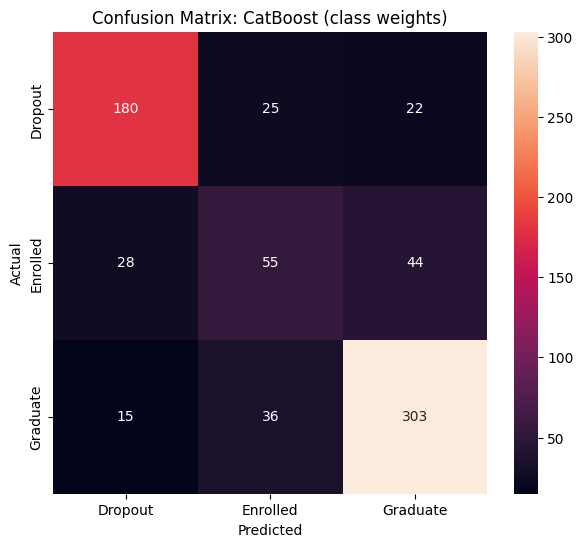

In [ ]:
# CatBoost (Native Catagorical + Class Weights)
# CatBoost works better with no one hot encoding

# Prepare CatBoost inputs (no one-hot encoding)
X_train_cb = X_train.copy()
X_val_cb = X_val.copy()

# Ensure object/category columns are treated as strings or category
for col in cat_cols:
    X_train_cb[col] = X_train_cb[col].astype(str)
    X_val_cb[col] = X_val_cb[col].astype(str)
    test_data[col] = test_data[col].astype(str)

# Cat feature indices (CatBoost needs indices, not names)
cat_feature_indices = [X_train_cb.columns.get_loc(c) for c in cat_cols]

# Compute class weights (inverse frequency)
class_counts = np.bincount(y_train)
class_weights = (class_counts.sum() / (len(class_counts) * class_counts)).tolist()

cat_model = CatBoostClassifier(
    loss_function="MultiClass",
    iterations=1200,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0,
    class_weights=class_weights
)

cat_model.fit(X_train_cb, y_train, cat_features=cat_feature_indices)
y_pred_cat = cat_model.predict(X_val_cb).astype(int).ravel()

print("CatBoost Results:")
evaluate_multiclass(y_val, y_pred_cat, target_classes)

cm_cat = confusion_matrix(y_val, y_pred_cat)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_cat, annot=True, fmt="d", xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: CatBoost (class weights)")
plt.show()


In [ ]:
# Now like Realinho et al. (2022):Permutation Feature Importance (Macro F1)

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

f1_macro_scorer = make_scorer(f1_score, average="macro", zero_division=0)

perm = permutation_importance(
    best_pipe,
    X_val,
    y_val,
    scoring=f1_macro_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# The feature names for permutation importance should be the original column names
# because permutation_importance shuffles original features of X_val
feature_names = X_val.columns

importances = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values(by="importance_mean", ascending=False)

importances.head(20)

,feature,importance_mean,importance_std
30,Curricular units 2nd sem (approved),0.183099,0.020755
16,Tuition fees up to date,0.030926,0.010407
24,Curricular units 1st sem (approved),0.027968,0.007101
3,Course,0.025770,0.007234
10,Mother's occupation,0.023010,0.004080
31,Curricular units 2nd sem (grade),0.016899,0.007152
28,Curricular units 2nd sem (enrolled),0.016570,0.007231
19,Age at enrollment,0.015536,0.006973
29,Curricular units 2nd sem (evaluations),0.014316,0.009809
12,Admission grade,0.011134,0.007155


Final Model Performance (Validation Set):
accuracy           0.7782
precision_macro    0.7273
recall_macro       0.7052
f1_macro           0.7131
f1_weighted        0.7708
dtype: float64

Classification Report (macro focus):

              precision    recall  f1-score   support

     Dropout       0.82      0.78      0.80       227
    Enrolled       0.55      0.43      0.48       127
    Graduate       0.82      0.90      0.85       354

    accuracy                           0.78       708
   macro avg       0.73      0.71      0.71       708
weighted avg       0.77      0.78      0.77       708



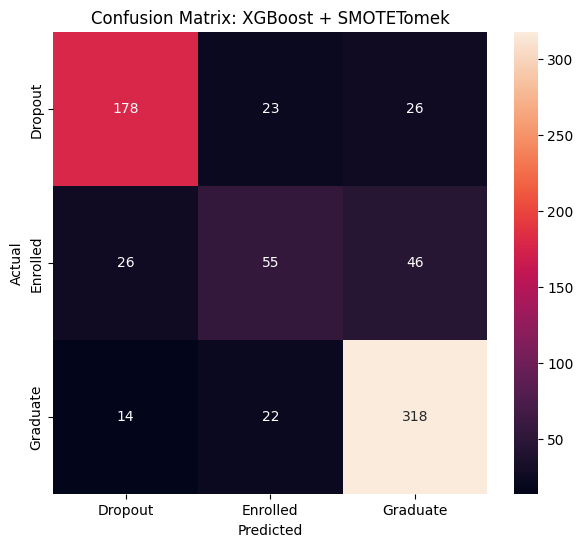

In [ ]:
# Final Model Evalaution (on the validation set)

# Fit best pipeline on training data only
best_pipe.fit(X_train, y_train)

# Predict on validation set
y_pred_best = best_pipe.predict(X_val)

print("Final Model Performance (Validation Set):")
evaluate_multiclass(y_val, y_pred_best, target_classes)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=target_classes,
            yticklabels=target_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix: {best_model} + {best_sampler}")
plt.show()


## Summary:

### Data Analysis Key Findings

*   The feature 'Curricular units 2nd sem (approved)' was identified as the most informative feature in predicting the 'Target' variable, exhibiting the highest mutual information score among all features.
*   The distributions of 'Curricular units 2nd sem (grade)' for both the train and test datasets showed a generally similar pattern, indicating consistency between the datasets, which is crucial for robust model generalization.
*   A Spearman correlation heatmap was successfully generated, visualizing the relationships between features and the target variable.
*   Cross-validation for multiple machine learning models (XGBoost, LightGBM, Logistic Regression, Random Forest, Gradient Boosting, and CatBoost) was successfully performed after addressing initial data type issues for XGBoost (by `LabelEncoding` categorical features) and CatBoost (by ensuring only integer-type columns were considered categorical).
*   A bar plot visualizing the mean cross-validation accuracies of all models was successfully generated.

### Insights or Next Steps

*   Leverage 'Curricular units 2nd sem (approved)' as a primary feature in model development due to its high mutual information score, potentially exploring its interaction with other variables.
*   Further analyze the model cross-validation results to identify the top-performing models and proceed with hyperparameter tuning or ensemble methods to maximize predictive accuracy.
